In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
import pandas as pd
import zipfile
import os
import re
import shutil
import seaborn as sns
import numpy as np

from tqdm import tqdm
from Kuzushijidataset import Kuzushijidataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib.font_manager import FontProperties
from torchvision import transforms, datasets, models

In [29]:
# k49 labe_classification
classes = ['あ - a', 'い - i', 'う - u', 'え - e', 'お - o', 
       'か - ka', 'き - ki', 'く - ku', 'け - ke', 'こ - ko', 
       'さ - sa', 'し - shi', 'す - su', 'せ - se', 'そ - so', 
       'た - ta', 'ち - chi', 'つ - tsu', 'て - te', 'と - to', 
       'な - na', 'に - ni', 'ぬ - nu', 'ね - ne', 'の - no',
       'は - ha', 'ひ - hi', 'ふ - fu', 'へ - he', 'ほ - ho',
       'ま - ma', 'み - mi', 'む - mu', 'め - me', 'も - mo',
       'や - ya', 'ゆ - yu', 'よ - yo', 
       'ら - ra', 'り - ri', 'る - ru', 'れ - re', 'ろ - ro',
       'わ - wa', 'ゐ - wi', 'ゑ - we', 'を - wo', 'ん - n', 'ゝ']

# Define the transformation for preprocessing the image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


hiragana_images_class = {0: 'A', 1: 'BA', 2: 'CHI', 3: 'DA', 4: 'E', 5: 'FU', 6: 'HA', 7: 'HE', 8: 'HI', 9: 'HO', 10: 'I', 11: 'JI', 12: 'KA', 13: 'KE', 14: 'KI', 15: 'KO', 16: 'KU', 17: 'MA', 18: 'ME', 19: 'MI', 20: 'MO', 21: 'MU', 22: 'N', 23: 'NA', 24: 'NE', 25: 'NI', 26: 'NO', 27: 'NU', 28: 'O', 29: 'PI', 30: 'RA', 31: 'RE', 32: 'RI', 33: 'RO', 34: 'RU', 35: 'SA', 36: 'SE', 37: 'SHI', 38: 'SO', 39: 'SU', 40: 'TA', 41: 'TE', 42: 'TO', 43: 'TSU', 44: 'U', 45: 'WA', 46: 'WO', 47: 'YA', 48: 'YO', 49: 'YU'}
hiragana_images_class = [k.lower() for k in list(hiragana_images_class.values())]

In [3]:
model = models.mobilenet_v3_large(weights=None)

model.features[0][0] = nn.Conv2d(in_channels=1, out_channels=model.features[0][0].out_channels, kernel_size=model.features[0][0].kernel_size)
model.classifier[-1] = torch.nn.Linear(in_features=model.classifier[-1].in_features, out_features=49)

Because the [inoueMashuu/hiragana-dataset](https://github.com/inoueMashuu/hiragana-dataset) contains different characters not in the [Kuzushiji-49](https://github.com/rois-codh/kmnist) (k49) dataset, we have to map the existing k49 mapping to the inoueMashuu/hiragana-dataset dataset (which is mapped different). And also exclude any tests to characters that does not exist in the k49 dataset.

Takes a while since I take image by image instead of batch size. This so I can verify each and every image. 

In [4]:
model.load_state_dict(torch.load('temp-2_large-3-100-0001.pth'))
model.eval()

image_dir = "hiragana_images/"

dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# label_map = hiragana_images: k49
label_map = {0: 0, 1: None, 2: 16, 3: None, 4: 3, 5: 27, 6: 25, 7: 28, 8: 26, 9: 29, 10: 1, 11: None, 12: 5, 13: 8, 14: 6, 15: 9, 16: 7, 17: 30, 18: 33, 19: 31, 20: 34, 21: 32, 22: 47, 23: 20, 24: 23, 25: 21, 26: 24, 27: 22, 28: 4, 29: None, 30: 38, 31: 41, 32: 39, 33: 42, 34: 40, 35: 10, 36: 13, 37: 11, 38: 14, 39: 12, 40: 15, 41: 18, 42: 19, 43: 17, 44: 2, 45: 43, 46: 46, 47: 35, 48: 37, 49: 36}

correct = 0
total = 0

with torch.inference_mode():
    for i in range(len(dataset)):
        img, label = dataset[i]
        # Continue if inoueMashuu/hiragana-dataset image is not in k49
        if label_map[label] == None:
            continue
        outputs = model(img.unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        # Continue if predicted k49 is not in inoueMashuu/hiragana-dataset
        if predicted.item() not in list(label_map.values()):
            continue 
        total += 1
        correct += 1 if list(label_map.values()).index(predicted.item()) ==  label else 0

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy of the model on the test images: {accuracy * 100:.2f}%')

Accuracy of the model on the test images: 53.78%


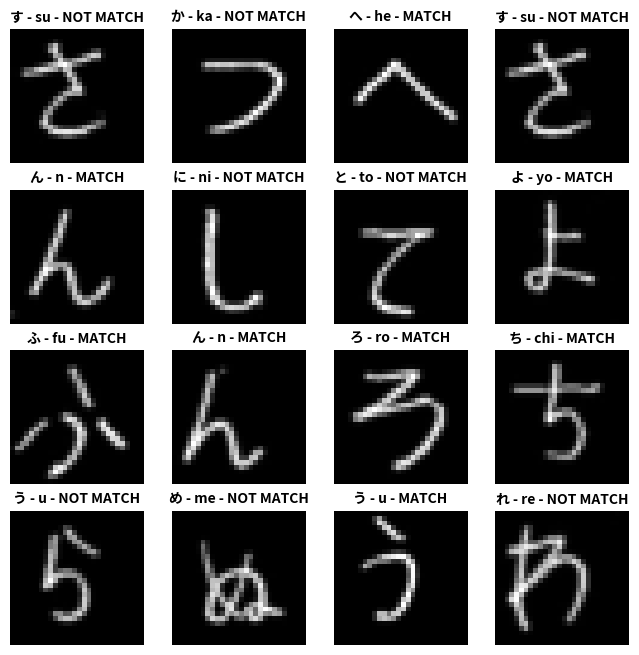

In [5]:
hiragana_mashu_map = list(label_map.keys())
k49_map = list(label_map.values())


figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
fp = FontProperties(fname='static/NotoSansJP-Bold.ttf')
with torch.inference_mode():
    for i in range(1, cols * rows + 1):
        while True:
            sample_idx = torch.randint(len(dataset), size=(1,)).item()
            img, label = dataset[sample_idx]
            if label_map[label] != None:
                break
        outputs = model(img.unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        try:
            figure.add_subplot(rows, cols, i)
            # plt.title(f"{class_labels[dataset_to_model_class_mapping[label]]} - {True if list(dataset_to_model_class_mapping.keys())[predicted] == label else False}", fontproperties=fp)
            plt.title(f"{classes[label_map[list(label_map.values()).index(predicted.item())]]} - {'MATCH' if list(label_map.values()).index(predicted.item()) == label else 'NOT MATCH'}", fontproperties=fp)
        except Exception as e:
            plt.title(f"Character not in k49", fontproperties=fp)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

Test dataset already exists!


100%|██████████| 302/302 [00:08<00:00, 37.74batch/s, accuracy=95]


number of testing samples results: 38547


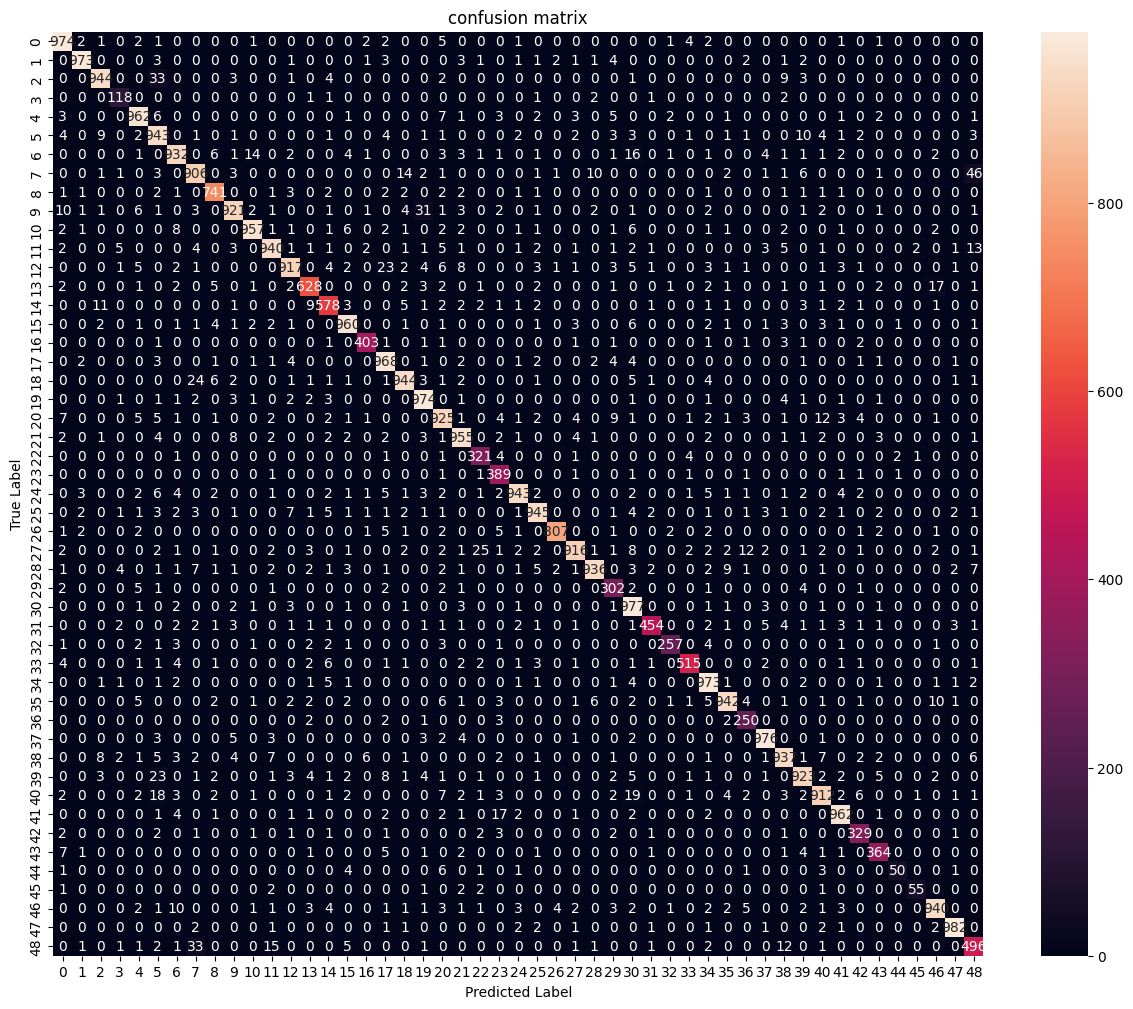

Confusion matrix, without normalization
Normalized confusion matrix


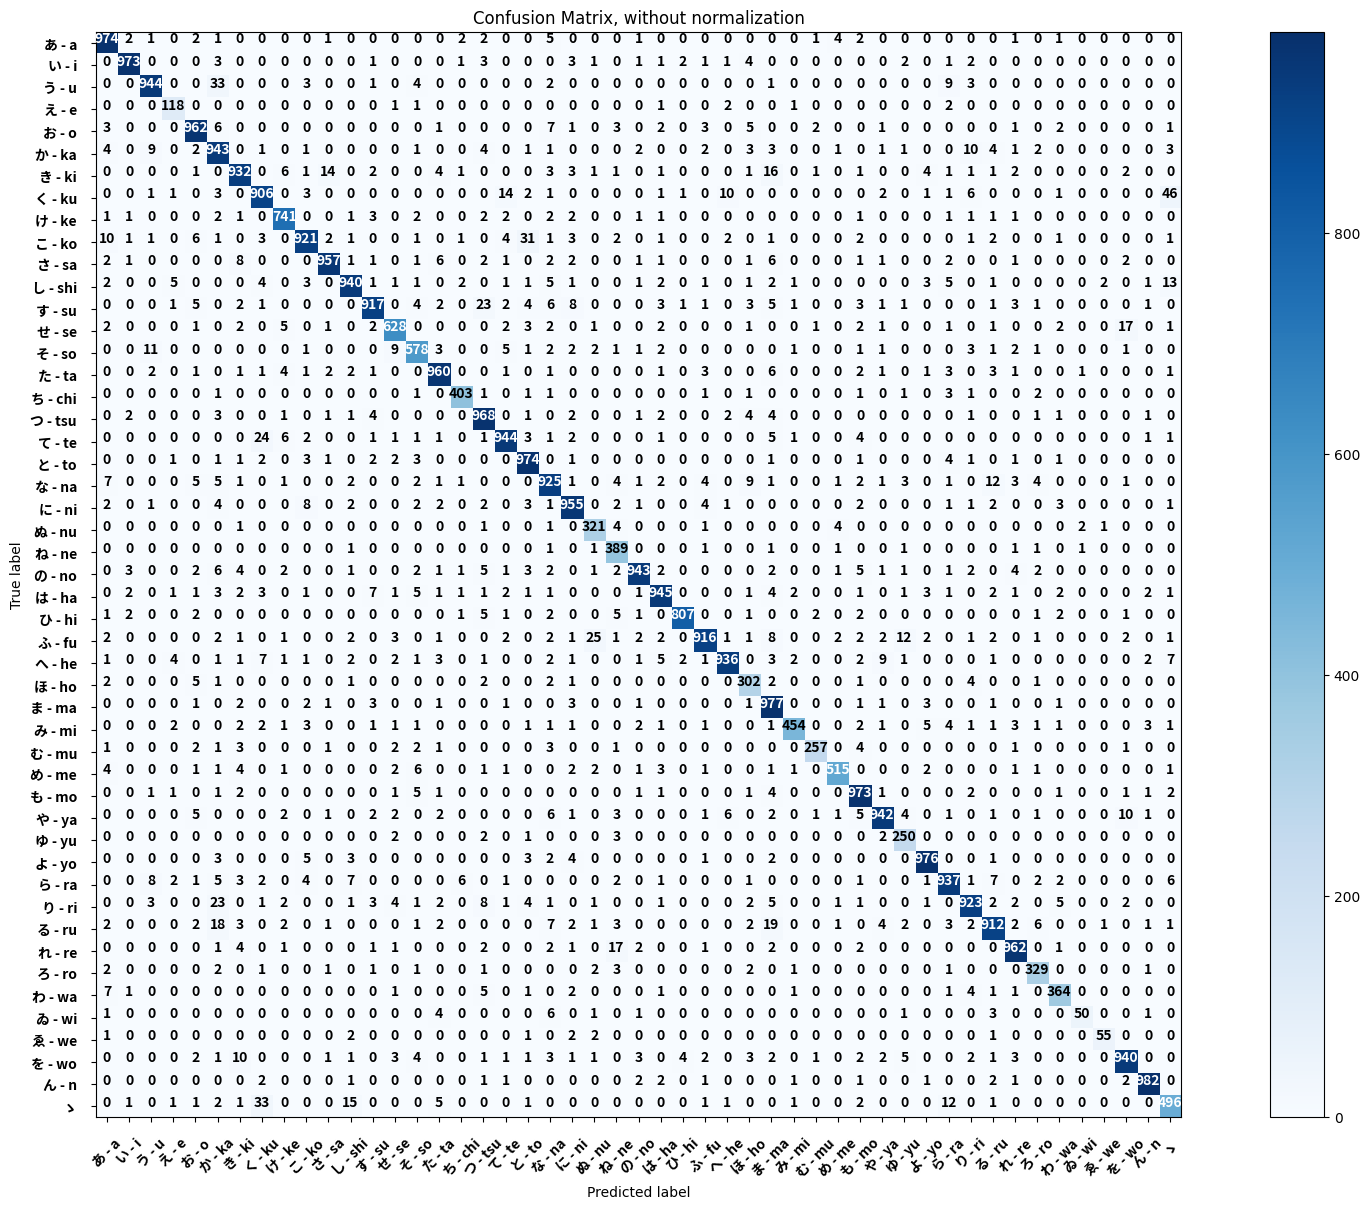

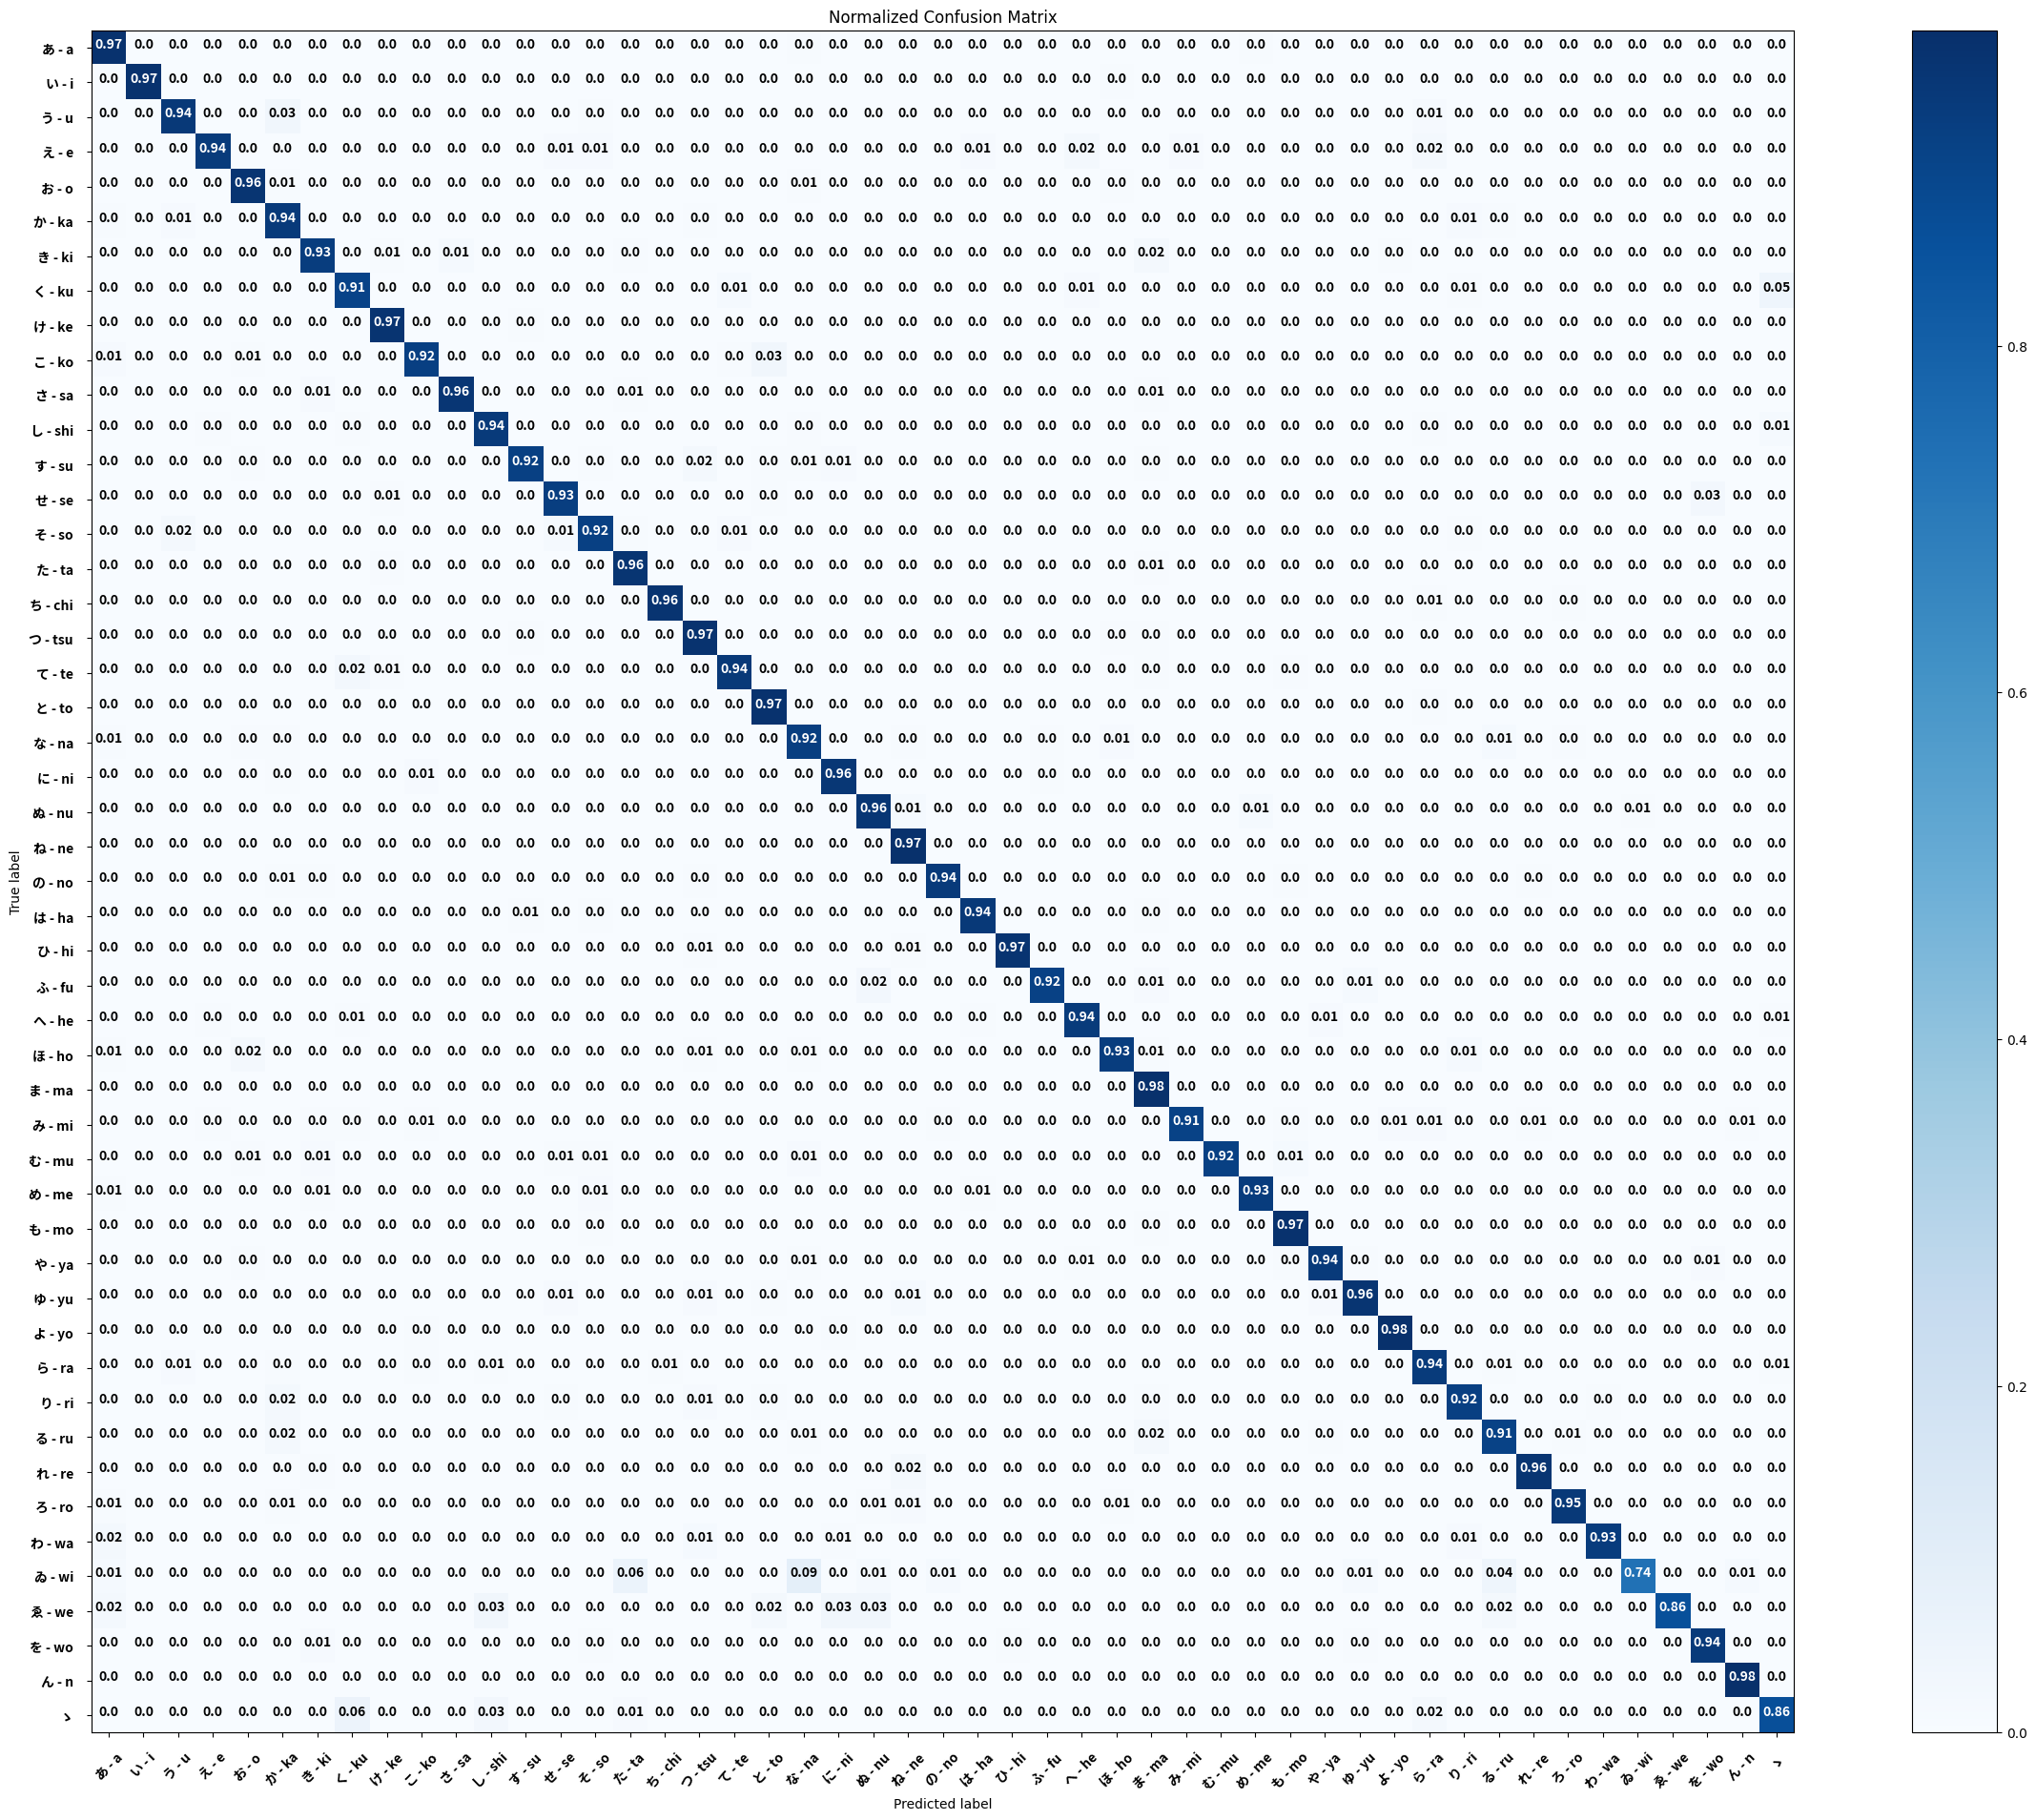

In [31]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

dataset = Kuzushijidataset("k49-dataset", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

y_pred_list = []
y_true_list = []
model.eval()
with torch.inference_mode():
    with tqdm(test_loader, unit="batch") as tepoch:
        for inp, labels in tepoch:
            inp, labels = inp.to(device), labels.to(device)
            y_test_pred = model(inp)
            acc = multi_acc(y_test_pred, labels)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            tepoch.set_postfix(accuracy = acc.item())
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())


flat_pred = []
flat_true = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        flat_pred.append(y_pred_list[i][j])
        flat_true.append(y_true_list[i][j])
        
print(f"number of testing samples results: {len(flat_pred)}")


idx2class = {k: k for k in range(len(classes))}
confusion_matrix_df = pd.DataFrame(confusion_matrix(flat_true, flat_pred)).rename(columns=idx2class, index=idx2class)
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix_df, annot=True, fmt='').set(title="confusion matrix", xlabel="Predicted Label", ylabel="True Label")
plt.show()

from matplotlib.font_manager import FontProperties

def plot_conf_matrix(cm, classes,
                     normalize=False,
                     title='Confusion matrix',
                     cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fp = FontProperties(fname="static/NotoSansJP-Bold.ttf")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45, fontproperties=fp)
    plt.yticks(np.arange(len(classes)), classes, fontproperties=fp)

    plt.gca().tick_params(axis='x', which='major', pad=10)
    plt.gca().tick_params(axis='y', which='major', pad=10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for (i, j), freq in np.ndenumerate(cm):
        plt.text(j, i, str(round(freq, 2)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", 
                 fontproperties=fp)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(18,12))
cm = confusion_matrix(flat_true, flat_pred)
plot_conf_matrix(cm, classes=classes,
                 title='Confusion Matrix, without normalization')

plt.figure(figsize=(25,19))
plot_conf_matrix(cm, classes=classes, normalize=True,
                 title='Normalized Confusion Matrix')

plt.savefig("normalized_confusion_matrix_tm.png")